In [576]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

from fastai import *
from fastai.vision import *
from fastai.vision.all import *

import gc
from tqdm.auto import *
from IPython.display import clear_output

In [577]:
device = torch.device("cpu")
selected_dtype = torch.float32

In [578]:
from functools import reduce
import torch
import torch.nn as nn
import torchvision

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x
    
class UpBlock(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, up_x):
        x = self.upsample(up_x)
        x = self.conv_block(x)
        return x


class ResNet50Autoencoder(nn.Module):
    def __init__(self, latent_channels=2048, float_type=selected_dtype):
        super().__init__()

        self.float_type = float_type

        resnet = torchvision.models.resnet.resnet50(weights='ResNet50_Weights.DEFAULT')
        down_blocks = []
        up_blocks = []

        self.input_block = nn.Sequential(*list(resnet.children()))[:3] # Conv2D, BatchNorm2D, ReLU
        self.input_pool = list(resnet.children())[3]

        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)

        self.down_blocks = nn.ModuleList(down_blocks)
        
        self.to_latent = ConvBlock(2048, latent_channels, with_nonlinearity=True)


        self.from_latent = ConvBlock(latent_channels, 2048)

        up_blocks.append(UpBlock(2048, 1024, upsampling_method="bilinear"))
        up_blocks.append(UpBlock(1024, 512, upsampling_method="bilinear"))
        up_blocks.append(UpBlock(512, 256, upsampling_method="bilinear"))
        up_blocks.append(UpBlock(in_channels=256, #128 + 64,
                                 out_channels=128,
                                 up_conv_in_channels=256,
                                 up_conv_out_channels=128, 
                                 upsampling_method="bilinear"))
        up_blocks.append(UpBlock(in_channels=128, #64 + 3,
                                 out_channels=64,
                                 up_conv_in_channels=128,
                                 up_conv_out_channels=64,
                                 upsampling_method="bilinear"))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, 3, kernel_size=1, stride=1)

        self.to(self.float_type)
        
    def encode(self, x):
        x = x.to(self.float_type)
        
        x = self.input_block(x)
        x = self.input_pool(x)

        for _, block in enumerate(self.down_blocks, 2):
            x = block(x)

        x = self.to_latent(x)

        x = torch.sigmoid(x)

        return x
        
    def decode(self, x):
        x = self.from_latent(x)

        for _, block in enumerate(self.up_blocks, 1):
            x = block(x)

        x = self.out(x)
        
        x = torch.sigmoid(x)

        return x

In [579]:
class Quantization:
    pass

class NormNoiseQuantization(nn.Module, Quantization):
    def __init__(self, quants: int = 2):
        super().__init__()
        self.quants = quants

    def forward(self, x):
        x = x + ((torch.rand_like(x, requires_grad=True) - 0.5) / (2 ** self.quants))
        return x
    
class DigitQuantization(nn.Module, Quantization):
    def __init__(self, quants: int = 2, orig_type = selected_dtype, q_type = torch.int8):
        super().__init__()
        self.quants = quants
        self.orig_type = orig_type
        self.q_type = q_type

    def forward(self, x):
        result = torch.floor(x.detach() * (2 ** self.quants) + 0.5)
        iinfo = torch.iinfo(self.q_type)
        result = torch.clamp(result, iinfo.min, iinfo.max)
        return result.to(self.q_type)
    
    def backward(self, x):
        return x.to(self.orig_type) / (2 ** self.quants)
    
# class DigitQuantization(nn.Module, Quantization):
#     def __init__(self, quants: int = 2, orig_type = selected_dtype, q_type = torch.int8):
#         super().__init__()
#         self.quants = quants
#         self.orig_type = orig_type
#         self.q_type = q_type

#     def forward(self, x):
#         return torch.round(x.detach() * (2 ** self.quants) + 0.5).to(self.q_type)
    
#     def backward(self, x):
#         return x.to(self.orig_type) / (2 ** self.quants)

In [259]:
model = ResNet50Autoencoder(1024, float_type=selected_dtype).to(device)

valid_quantization = DigitQuantization(2, orig_type=selected_dtype, q_type=torch.uint8).to(device)
# valid_quantization = NormNoiseQuantization(8).to(device)

In [260]:
saved_state = torch.load("../weights/L3_resnet50_full130k_model_19_l_0,01.pth", map_location=torch.device('cpu'))

In [261]:
model.load_state_dict(saved_state['model_state_dict'])

<All keys matched successfully>

In [580]:
def test_images(paths: list[str]):
  _, axs = plt.subplots(len(paths), 2, figsize=(6, 3 * len(paths)))

  for i, path in enumerate(paths):
    test = torchvision.io.read_image(path).unsqueeze(0).to(torch.float32) / 256.0
    model.eval()

    print(f"{path}: Original shape: {list(test.shape[1:])}")

    test = test.to(device)

    intermediate = model.encode(test)
    intermediate = valid_quantization.forward(intermediate)

    print(f"{path}: Intermediate form: {list(intermediate.shape[1:])}")

    intermediate = valid_quantization.backward(intermediate)
    result = model.decode(intermediate)

    ax = axs if len(paths) == 1 else axs[i]

    ax[0].imshow(test[0].detach().cpu().permute(1, 2, 0).numpy())
    ax[0].set_title("Original")
    ax[1].imshow(result[0].detach().cpu().permute(1, 2, 0).numpy())
    ax[1].set_title("Decompressed")

  plt.show()


In [581]:
def run_image_through(path: str):
  test = torchvision.io.read_image(path).unsqueeze(0).to(torch.float32) / 256.0
  model.eval()

  print(f"{path}: Original shape: {list(test.shape[1:])}")

  test = test.to(device).detach()

  intermediate = model.encode(test)
  intermediate = intermediate.detach()
  intermediate = valid_quantization.forward(intermediate)

  print(f"{path}: Intermediate form: {list(intermediate.shape[1:])}")

  intermediate = valid_quantization.backward(intermediate)
  result = model.decode(intermediate)

  path_parts = path.split(".")
  pref, ext = ".".join(path_parts[:-1]), path_parts[-1]

  new_path = f"{pref}_compressed.{ext}"
  print("Saving to:", new_path)

  torchvision.io.write_jpeg((result[0].detach().cpu() * 256).to(torch.uint8), new_path, quality=100)


In [263]:
run_image_through("../test/moscow.jpeg")

../test/moscow.jpeg: Original shape: [3, 854, 1280]
../test/moscow.jpeg: Intermediate form: [1024, 27, 40]
Saving to: ../test/moscow_compressed.jpeg


In [582]:
def encode_bin(path: str, model: ResNet50Autoencoder, valid_quantization: Quantization):
  test = torchvision.io.read_image(path).unsqueeze(0).to(torch.float32) / 256.0
  
  test = test.to(device).detach()

  intermediate = model.encode(test)
  intermediate = intermediate.detach()
  intermediate = valid_quantization.forward(intermediate)

  bin_repr = intermediate[0].detach().cpu()

  return bin_repr

def decode_bin(bin_repr: torch.Tensor, model: ResNet50Autoencoder, valid_quantization: Quantization):
  if len(bin_repr.shape) == 3:
    bin_repr = bin_repr.unsqueeze(0)

  intermediate = valid_quantization.backward(bin_repr)
  result = model.decode(intermediate)

  return result

In [583]:
import zlib

def compress_file(path: str, cleanup: bool = True):
    with open(path, 'rb') as f_in:
        # Read the contents of the file
        bin_np_fb = f_in.read()

    # Compress the data using zlib
    compressed_data = zlib.compress(bin_np_fb, level=9)

    # Open the output file in binary mode
    with open(f'{path}.zlib', 'wb') as f_out:
        # Write the compressed data to the output file
        f_out.write(compressed_data)

    if cleanup:
        os.remove(path)

    return f'{path}.zlib'

def decompress_file(path: str, cleanup: bool = True):
    assert(path.endswith(".zlib"))

    with open(path, 'rb') as f_in:
        # Read the contents of the file
        compressed_data = f_in.read()

    # Decompress the data using zlib
    bin_np_fb = zlib.decompress(compressed_data)

    with open(path[:-5], 'wb') as f_out:
        # Write the compressed data to the output file
        f_out.write(bin_np_fb)

    if cleanup:
        os.remove(path)

In [584]:
def load_model(weights_path: str, quants: int = 8):
    target_type = None
    if quants <= 8:
        target_type = torch.uint8
    elif quants <= 16:
        target_type = torch.int32
    elif quants <= 32:
        target_type = torch.int64
    else:
        raise ValueError("Invalid number of quantization bits")

    model = ResNet50Autoencoder(1024, float_type=selected_dtype)
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'))['model_state_dict'])
    model.eval()

    valid_quantization = DigitQuantization(quants, orig_type=selected_dtype, q_type=target_type)

    return model, valid_quantization


def compress_image(path: str, weights_path: str, quants: int = 8, new_path: str = None, cleanup: bool = True):
    model, valid_quantization = load_model(weights_path, quants)
    
    bin_repr = encode_bin(path, model, valid_quantization)

    new_path = f"{new_path}.nc" if new_path else f"{path}.nc"

    torch.save(bin_repr, new_path)

    saved_to = compress_file(new_path, cleanup=cleanup)
    print("Saved to:", saved_to)

def decompress_image(path: str, weights_path: str, quants: int = 8, cleanup: bool = True, force: bool = False):
    assert(path.endswith(".nc.zlib"))

    decompress_file(path, cleanup=False)

    bin_repr = torch.load(path[:-5], map_location=torch.device('cpu'))

    model, valid_quantization = load_model(weights_path, quants)
    result = decode_bin(bin_repr, model, valid_quantization)

    path_parts = path.split(".")
    pref, ext = ".".join(path_parts[:-3]), path_parts[-3]

    new_path = f"{pref}.{ext}"

    to_write = force or (not os.path.exists(new_path))
    if (to_write):
        print("Saving to:", new_path)

    if to_write and ext.lower() == "jpeg" or ext.lower() == "jpg":
        torchvision.io.write_jpeg((result[0].detach().cpu() * 256).to(torch.uint8), new_path, quality=100)
    elif to_write and ext == "png":
        torchvision.io.write_png((result[0].detach().cpu() * 256).to(torch.uint8), new_path)
    elif not to_write:
        pass
    else:
        raise Exception("Unknown extension")
    
    if cleanup:
        os.remove(path)
        os.remove(path[:-5])

    return result

In [585]:
compress_image("../test/audi.jpeg", "../weights/L3_resnet50_full130k_model_14_l_0,006.pth", quants=8, new_path="../test/audi_d.jpeg", cleanup=False)
decompress_image("../test/audi_d.jpeg.nc.zlib", "../weights/L3_resnet50_full130k_model_14_l_0,006.pth", quants=8, force=True)

Saved to: ../test/audi_d.jpeg.nc.zlib
Saving to: ../test/audi_d.jpeg


tensor([[[[0.5366, 0.5461, 0.5649,  ..., 0.2121, 0.2332, 0.2625],
          [0.5242, 0.5604, 0.5571,  ..., 0.0484, 0.2385, 0.2479],
          [0.5065, 0.5613, 0.5578,  ..., 0.2395, 0.2430, 0.2249],
          ...,
          [0.0605, 0.0627, 0.0592,  ..., 0.0523, 0.0693, 0.0969],
          [0.0543, 0.0602, 0.0522,  ..., 0.0480, 0.0567, 0.0856],
          [0.0607, 0.0587, 0.0580,  ..., 0.0623, 0.0624, 0.0886]],

         [[0.4177, 0.4149, 0.4384,  ..., 0.1649, 0.1677, 0.2099],
          [0.4238, 0.4465, 0.4379,  ..., 1.0000, 0.1657, 0.1829],
          [0.4100, 0.4577, 0.4471,  ..., 0.2213, 0.2071, 0.1867],
          ...,
          [0.0549, 0.0675, 0.0628,  ..., 0.0336, 0.0444, 0.0436],
          [0.0507, 0.0621, 0.0532,  ..., 0.0369, 0.0404, 0.0437],
          [0.0582, 0.0593, 0.0567,  ..., 0.0437, 0.0448, 0.0509]],

         [[0.3065, 0.2923, 0.2981,  ..., 0.1925, 0.2136, 0.2450],
          [0.2975, 0.3261, 0.3184,  ..., 0.0434, 0.1864, 0.1886],
          [0.2923, 0.3325, 0.3257,  ..., 0

In [586]:
# MSE
def mse_loss(result, target):
    result = result.view(result.size(0), -1)
    target = target.view(target.size(0), -1)
    mses = F.mse_loss(result, target, reduction='none').mean(dim=1)
    return torch.mean(mses)

# PSNR
def psnr(result, target):
    result = result.view(result.size(0), -1)
    maxes = torch.max(result, dim = 1)[0] ** 2
    target = target.view(target.size(0), -1)
    mses = F.mse_loss(result, target, reduction='none').mean(dim=1)
    psnrs = 10.0 * torch.log10(maxes.to(torch.float32) / mses.to(torch.float32)).to(selected_dtype)
    return torch.mean(psnrs)

# # Intermediate vector entropy
# def latent_entropy_aprox(result):
#     result = result.to(torch.float32)
#     probabilities = F.softmax(result, dim=0)
#     entropy = F.cross_entropy(probabilities, torch.ones_like(probabilities) / probabilities.size(0))
#     return entropy.to(selected_dtype)
# Intermediate vector entropy

def latent_entropy_aprox(result):
    unique, counts = torch.unique(result, return_counts=True)
    probabilities = counts.float() / result.numel()
    entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-9))  # Add a small constant for numerical stability
    return entropy.to(selected_dtype)

# Perseptual loss
class VGGFeatures(nn.Module):
    def __init__(self, feature_layers = {3, 6, 11, 16}):
        super(VGGFeatures, self).__init__()
        vgg = torchvision.models.vgg11(weights="VGG11_Weights.DEFAULT")
        vgg.eval()
        for param in vgg.parameters():
            param.requires_grad = False

        self.vgg = vgg
        self.feature_layers = feature_layers

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.vgg.features):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

vgg_features = VGGFeatures().to(device)
def vgg_perceptual_loss(result, target, vgg_to_use=vgg_features):
    result = vgg_to_use(result)
    target = vgg_to_use(target)
    return sum(F.mse_loss(orig, decomp) for orig, decomp in zip(result, target))

In [587]:
def produce_nc_and_jpeg(path: str, weights_path: str):
    path_parts = path.split(".")
    pref, ext = ".".join(path_parts[:-1]), path_parts[-1]

    nc_paths = []
    jpeg_paths = []

    quants = [1, 2, 4, 8, 16]
    for q in tqdm(quants, desc="Neural Codec"):
        compress_image(path, weights_path, quants=q, new_path=f"{pref}_q{q}.{ext}")
        nc_paths.append((f"{pref}_q{q}.{ext}.nc.zlib", q))


    image_tensor = torchvision.io.read_image(path)

    jpeg_qualities = [10, 30, 60, 80, 90, 100]
    for q in tqdm(jpeg_qualities, desc="JPEG"):
        torchvision.io.write_jpeg(image_tensor, f"{pref}_p{q}.jpeg", quality=q)
        jpeg_paths.append(f"{pref}_p{q}.jpeg")

    return nc_paths, jpeg_paths

In [588]:
def compare(h, w, metric, metric_title, target_path: str, nc_paths: list, jpeg_paths: list, weights_path: str, axis = plt):
    target = (torchvision.io.read_image(target_path).to(torch.float32) / 256.0).detach().cpu()

    nc_psnrs = []
    nc_bpp = []
    for nc_path, nc_quants in nc_paths:
        nc_tensor = decompress_image(
            nc_path,
            weights_path,
            quants=nc_quants,
            cleanup=False
            )[0].detach().cpu()
        bit_size = os.path.getsize(nc_path) * 8

        nc_psnrs.append(metric(nc_tensor, target))
        nc_bpp.append(bit_size / (h * w))

    jpeg_psnrs = []
    jpeg_bpp = []
    for jpeg_path in jpeg_paths:
        jpeg_tensor = torchvision.io.read_image(jpeg_path).to(torch.float32) / 256.0
        bit_size = os.path.getsize(jpeg_path) * 8

        jpeg_psnrs.append(metric(jpeg_tensor, target))
        jpeg_bpp.append(bit_size / (h * w))

    axis.plot(nc_bpp, nc_psnrs, label="Neural Codec", marker="x", color="red")
    axis.plot(jpeg_bpp, jpeg_psnrs, label="JPEG", marker="x", color="blue")
    axis.set_xlabel("bpp")
    axis.set_ylabel(metric_title)
    axis.legend()
    axis.grid(True)

In [591]:
weights_path = "../weights/L3_resnet50_full130k_model_14_l_0,006.pth"
nc_paths, jpeg_paths = produce_nc_and_jpeg("../test/comparison/baboon.png", weights_path)

Neural Codec:   0%|          | 0/5 [00:00<?, ?it/s]

Saved to: ../test/comparison/baboon_q1.png.nc.zlib
Saved to: ../test/comparison/baboon_q2.png.nc.zlib
Saved to: ../test/comparison/baboon_q4.png.nc.zlib
Saved to: ../test/comparison/baboon_q8.png.nc.zlib
Saved to: ../test/comparison/baboon_q16.png.nc.zlib


JPEG:   0%|          | 0/6 [00:00<?, ?it/s]

Saving to: ../test/comparison/baboon_q1.png
Saving to: ../test/comparison/baboon_q2.png
Saving to: ../test/comparison/baboon_q4.png
Saving to: ../test/comparison/baboon_q8.png
Saving to: ../test/comparison/baboon_q16.png


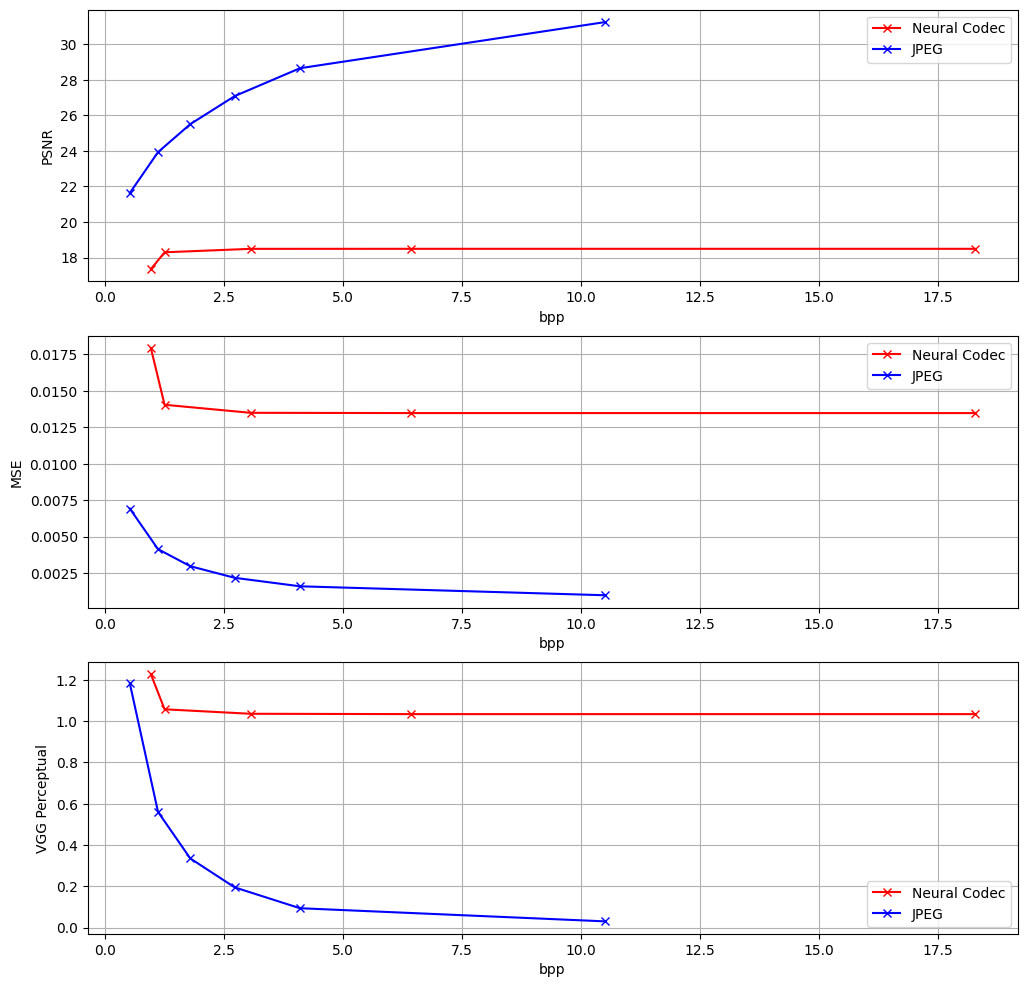

In [592]:
_, axs = plt.subplots(3, 1, figsize=(12, 12))

compare(512, 512, psnr, "PSNR", "../test/comparison/baboon.png", nc_paths, jpeg_paths, weights_path, axs[0])
compare(512, 512, mse_loss, "MSE", "../test/comparison/baboon.png", nc_paths, jpeg_paths, weights_path, axs[1])
compare(512, 512, vgg_perceptual_loss, "VGG Perceptual", "../test/comparison/baboon.png", nc_paths, jpeg_paths, weights_path, axs[2])

plt.show()

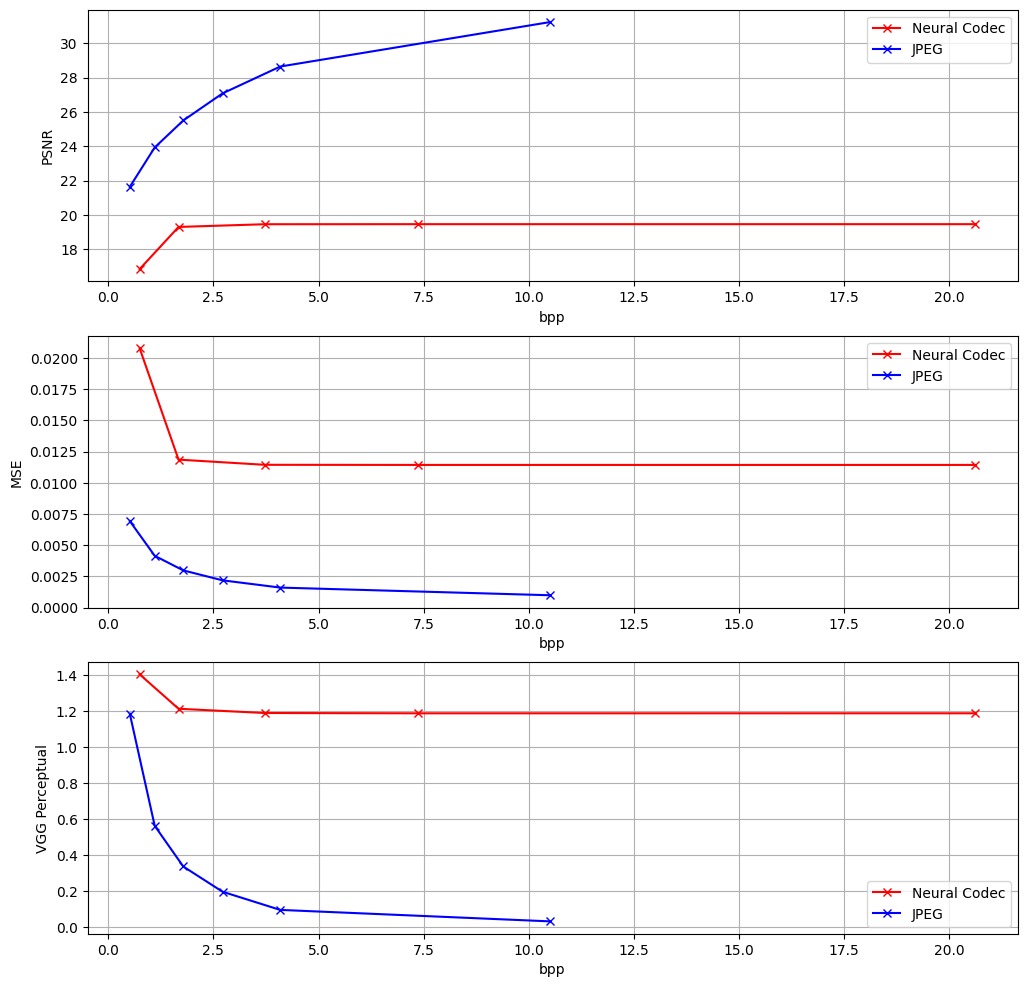

In [ ]:
_, axs = plt.subplots(3, 1, figsize=(12, 12))

compare(512, 512, psnr, "PSNR", "../test/comparison/baboon.png", nc_paths, jpeg_paths, axs[0])
compare(512, 512, mse_loss, "MSE", "../test/comparison/baboon.png", nc_paths, jpeg_paths, axs[1])
compare(512, 512, vgg_perceptual_loss, "VGG Perceptual", "../test/comparison/baboon.png", nc_paths, jpeg_paths, axs[2])

plt.show()